# Implementation of different versions of the benefit difference fairness function

In [1]:
import numpy as np
from consequential_learning import train
from feature_map import IdentityFeatureMap
from functions import cost_utility, demographic_parity
from src.plotting import plot_results_over_time

## The parameters used by the the original authors  

In [2]:
dim_x = 1
training_parameters = {
    'keep_collected_data': False,
    'use_sensitve_attributes': False,
    'time_steps':200,
    'batch_size':512,
    'num_iterations': 32,
    'learning_parameters': {
        'learning_rate': 0.5,
        'decay_rate': 0.8,
        'decay_step': 30
    },
    'fairness_rate':1000,
    'fraction_protected':0.5,
    'num_test_samples': 2000,
    'bias': True,
    'benefit_value_function': demographic_parity
}
def util_func(**util_params):
    util = cost_utility(cost_factor=0.55, **util_params)
    return util

dim_theta = dim_x + 1 if training_parameters['bias'] else dim_x
training_parameters['theta'] = [-3.5, 0.6]
training_parameters['feature_map'] = IdentityFeatureMap(dim_theta)
training_parameters['num_decisions'] = training_parameters['num_iterations'] * training_parameters['batch_size']
training_parameters['utility_value_function'] = util_func


## Training loop

In [3]:
def train_multiple(training_parameters):
    benefit_deltas = []
    utilities = []
    for i in range(1, 21):
        benefit_delta = []
        utility = []
        j = 0

        print("Current iteration: {}".format(i))

        for u, bd in train(**training_parameters):
            benefit_delta.append(bd)
            utility.append(u)
            j += 1

        benefit_deltas.append(np.array(benefit_delta))
        utilities.append(np.array(utility))

    plot_results_over_time(np.array(utilities), np.array(benefit_deltas))

## Correct Benefit Difference

Current iteration: 1
/home/fkretschmar/Documents/master-thesis/src/policy.py:302: RuntimeWarning: overflow encountered in exp
  denominator = np.expand_dims(1.0 + np.exp(np.matmul(phi, self.theta)), axis=1)
/home/fkretschmar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
Current iteration: 2
Current iteration: 3
Current iteration: 4
Current iteration: 5
Current iteration: 6
Current iteration: 7
Current iteration: 8
Current iteration: 9
Current iteration: 10
Current iteration: 11
Current iteration: 12
Current iteration: 13
Current iteration: 14
Current iteration: 15
Current iteration: 16
Current iteration: 17
Current iteration: 18
Current iteration: 19
Current iteration: 20


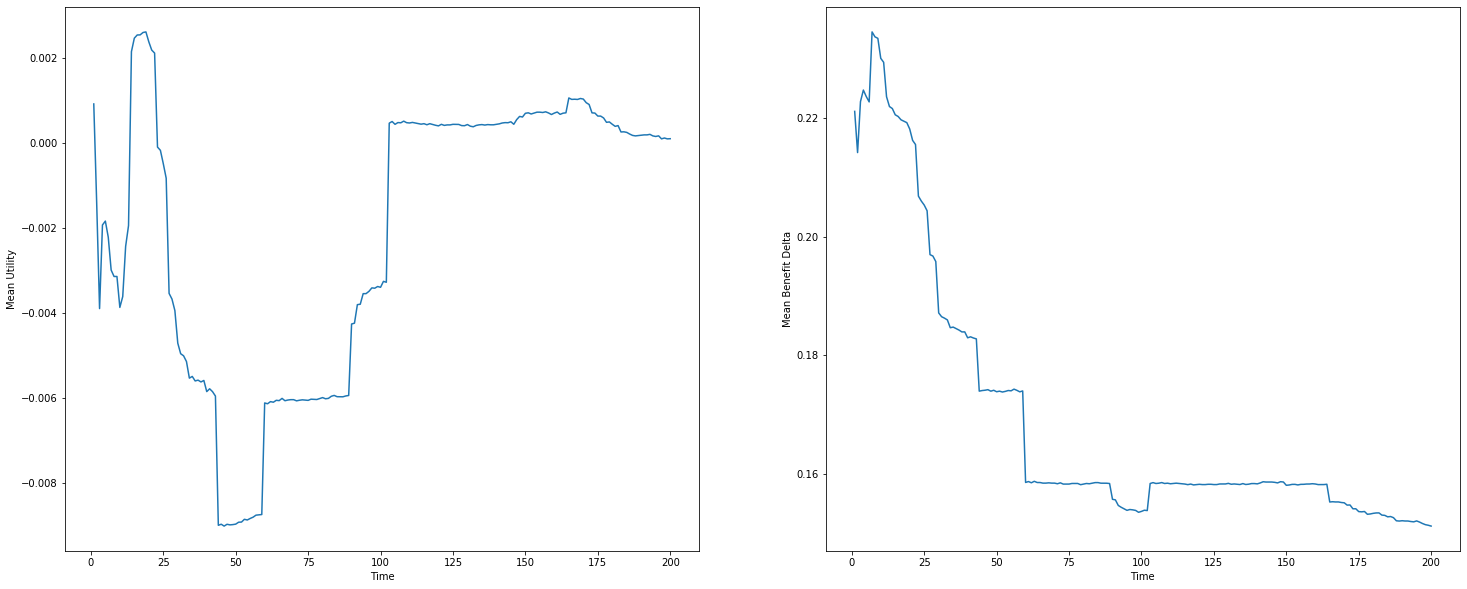

In [4]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]

    benefit = policy.benefit_function(decisions=decisions, y=y)
    phi = policy.feature_map(policy._extract_features(x, s))
    denominator = np.expand_dims((1.0 + np.exp(np.matmul(phi, policy.theta))), axis=1)

    benefit_grad = benefit * phi/denominator

    if ips_weights is not None:
        benefit *= ips_weights
        benefit_grad *= ips_weights
        
    # benefit-difference * grad-benefit-difference
    return policy._mean_difference(benefit, s) * policy._mean_difference(benefit_grad, s)

training_parameters['fairness_function'] = fairness_function

train_multiple(training_parameters)

## Wrong Fairness Benefit Difference: IPS weighting only once

Current iteration: 1
/home/fkretschmar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
Current iteration: 2
Current iteration: 3
Current iteration: 4
Current iteration: 5
Current iteration: 6
Current iteration: 7
Current iteration: 8
Current iteration: 9
Current iteration: 10
Current iteration: 11
Current iteration: 12
Current iteration: 13
Current iteration: 14
Current iteration: 15
Current iteration: 16
Current iteration: 17
Current iteration: 18
Current iteration: 19
Current iteration: 20


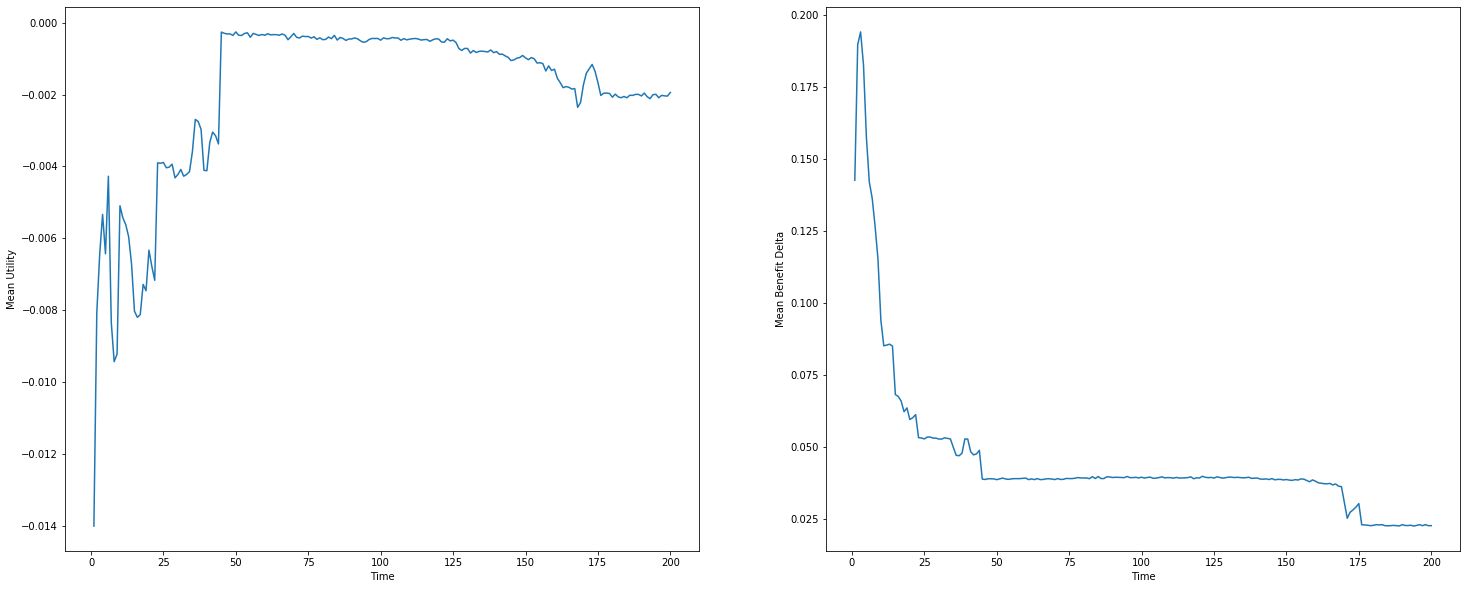

In [5]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]

    benefit = policy.benefit_function(decisions=decisions, y=y)
    phi = policy.feature_map(policy._extract_features(x, s))
    denominator = np.expand_dims((1.0 + np.exp(np.matmul(phi, policy.theta))), axis=1)

    benefit_grad = benefit * phi/denominator

    if ips_weights is not None:
        benefit_grad *= ips_weights
        
    # benefit-difference * grad-benefit-difference
    return policy._mean_difference(benefit, s) * policy._mean_difference(benefit_grad, s)

training_parameters['fairness_function'] = fairness_function

train_multiple(training_parameters)

## Wrong Fairness Benefit Difference: IPS weighting only once and always use gradient denominator

Current iteration: 1
Current iteration: 2
Current iteration: 3
Current iteration: 4
Current iteration: 5
Current iteration: 6
Current iteration: 7
Current iteration: 8
Current iteration: 9
Current iteration: 10
/home/fkretschmar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
Current iteration: 11
Current iteration: 12
Current iteration: 13
Current iteration: 14
Current iteration: 15
Current iteration: 16
Current iteration: 17
Current iteration: 18
Current iteration: 19
Current iteration: 20


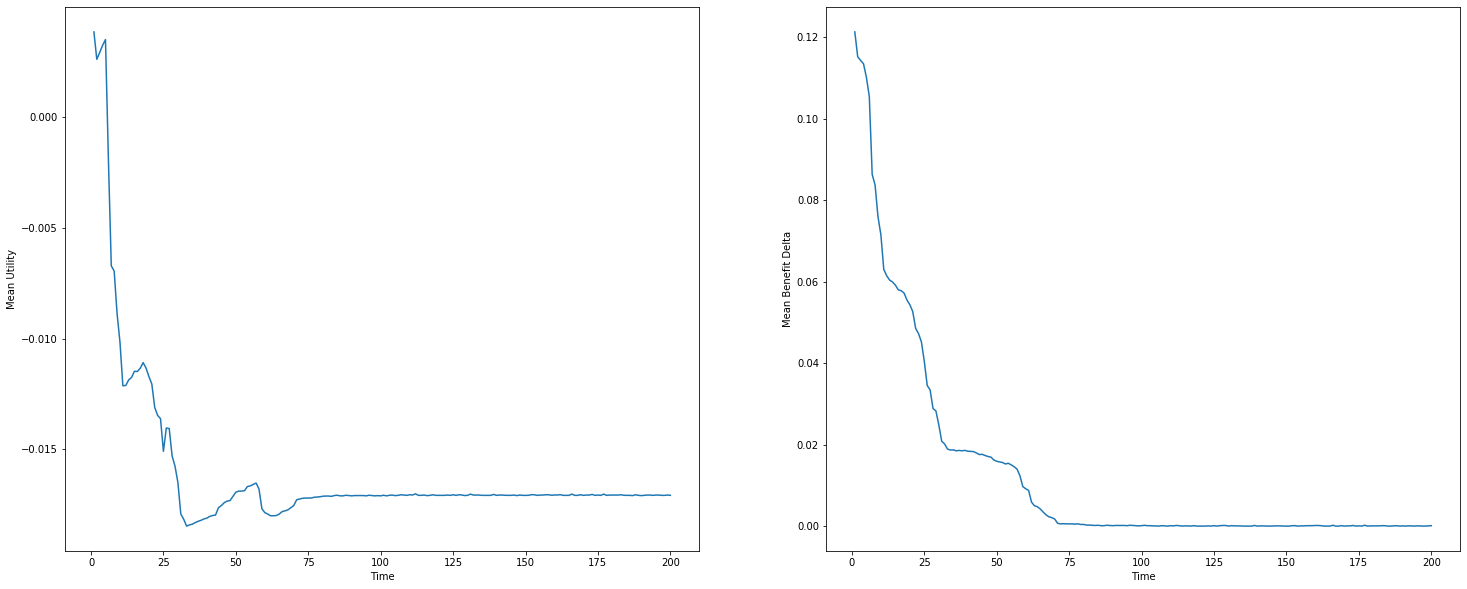

In [6]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]

    benefit = policy.benefit_function(decisions=decisions, y=y)
    phi = policy.feature_map(policy._extract_features(x, s))
    denominator = np.expand_dims((1.0 + np.exp(np.matmul(phi, policy.theta))), axis=1)

    benefit /= denominator
    benefit_grad = benefit * phi

    if ips_weights is not None:
        benefit_grad *= ips_weights
        
    # benefit-difference * grad-benefit-difference
    return policy._mean_difference(benefit, s) * policy._mean_difference(benefit_grad, s)

training_parameters['fairness_function'] = fairness_function

train_multiple(training_parameters)

## Correct Covariance Fairness

In [9]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]

    phi = policy.feature_map(policy._extract_features(x, s))
    denominator = np.expand_dims((1.0 + np.exp(np.matmul(phi, policy.theta))), axis=1)
    benefit = policy.benefit_function(decisions=decisions, y=y)

    if ips_weights is not None:
        mu_s = np.mean(s * ips_weights, axis=0)
    else:
        mu_s = np.mean(s, axis=0)

    covariance = (s - mu_s) * benefit
    covariance_grad = covariance * phi/denominator

    if ips_weights is not None:
        covariance *= ips_weights
        covariance_grad *= ips_weights

    return np.mean(covariance, axis=0) * np.mean(covariance_grad, axis=0)

training_parameters['fairness_function'] = fairness_function

train_multiple(training_parameters)

## Wrong Covariance Fairness: IPS weighting only once

In [8]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]

    phi = policy.feature_map(policy._extract_features(x, s))
    denominator = np.expand_dims((1.0 + np.exp(np.matmul(phi, policy.theta))), axis=1)
    benefit = policy.benefit_function(decisions=decisions, y=y)

    mu_s = np.mean(s, axis=0)

    covariance = (s - mu_s) * benefit
    covariance_grad = covariance * phi/denominator

    if ips_weights is not None:
        covariance_grad *= ips_weights

    return np.mean(covariance, axis=0) * np.mean(covariance_grad, axis=0)